In [97]:
#pip install tensorflow==2.10.0

In [98]:
#pip list

In [99]:
# python -V

In [100]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
# from visualkeras import layered_view

# Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense,Concatenate,GlobalAveragePooling2D,GlobalAveragePooling1D
from tensorflow.keras.models import Model
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
# 從 TensorFlow Hub 載入 VGGish 模型
vggish = hub.load('https://www.kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1')

Attaching model 'google/vggish/tensorflow2/vggish/1' to your Kaggle notebook...


In [102]:
# Converting list into dataframe
pickle_filename="/kaggle/input/vggmfcc2/vggish_music_data_feature_class (1).pkl"
#pickle_filename="/kaggle/input/audio-5000-22khz/audio_5000_22kHz.pkl"
data = pd.read_pickle(pickle_filename)
data = pd.DataFrame(data, columns = ['vigg', 'Class'])
data.rename(columns = {'vigg':'feature1'}, inplace = True) 
data.head()
# print(data['features'].size)
# shape=(43,128)
# maxshape=(43,128)
# inconsistent=[]
# i=0;
# for arr in data['features']:
#     if(arr.shape!=shape):
#         inconsistent.append(i)
#         maxshape=arr.shape
#     i+=1
# print(inconsistent)
# print(maxshape)

,feature1,Class
0,"[[-0.21395662, 0.28909662, 0.3015396, -0.45216...",disco
1,"[[-0.39721903, 0.11945252, 0.3367351, -0.22886...",disco
2,"[[-0.29069492, 0.064830065, 0.4863159, -0.6044...",disco
3,"[[-0.7537017, 0.18824726, 0.005084187, -0.1591...",disco
4,"[[-0.2572439, 0.108981386, 0.19699858, -0.3716...",disco


In [103]:
# 假設你的數據列名為 'Class'
# class_labels = data['Class'].unique()
class_labels=['disco','metal','reggae','blues','rock','classical', 'jazz', 'hiphop','country', 'pop']
#class_labels=['blues','classical','country','folk','hiphop','jazz','metal','opera','pop','rock']
print(class_labels)

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [104]:
x = data['feature1'].tolist()
x = pad_sequences(x, dtype = 'float32', padding = 'post', truncating = 'post')
x.shape

(999, 43, 128)

In [105]:
# x1 = []

# # Padding or truncating the arrays to a fixed length
# for i in data['feature2']:
#      x1.append(np.transpose(pad_sequences(i,maxlen=1293,dtype = 'float32', padding = 'post', truncating = 'post')))
# x1=np.array(x1)
# x1.shape

In [106]:
# Encoding class labels
label_mapping={'disco':0, 'metal':1, 'reggae':2, 'blues':3, 'rock':4, 'classical':5, 'jazz':6, 'hiphop':7,
 'country':8, 'pop':9}
# label_mapping={'blues': 0,'classical': 1,'country': 2,'folk': 3,'hiphop': 4,
#                         'jazz': 5,'metal': 6,'opera': 7,'pop': 8,'rock': 9}
encoder = LabelEncoder()
y= encoder.fit_transform([label_mapping[label] for label in data['Class']])
y = to_categorical(y)

# 顯示 one hot encoder 結果的形狀（樣本數）
num_samples = y.shape[0]
print(f'總共有 {num_samples} 筆樣本')

# 顯示 one hot encoder 的結果
print(type(y))

總共有 999 筆樣本
<class 'numpy.ndarray'>


In [107]:
# 使用固定的隨機種子進行切割
#trainX, testX,trainX1, testX1, trainY, testY = train_test_split(x,x1, y, test_size=0.1, random_state=0)
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.1, random_state=0)
trainX, valX, trainY, valY = train_test_split(trainX,trainY, test_size=0.2, random_state=0)
# 在這裡，trainX 是訓練集的特徵，testX 是測試集的特徵
# trainY 是訓練集的標籤，testY 是測試集的標籤

# 顯示劃分後的訓練集和測試集大小
# print(f"   特徵1大小：{len(trainX)} 樣本 特徵2大小：{len(trainX1)} 樣本")
# print(f"測試特徵1大小：{len(testX)} 樣本  測試特徵2大小：{len(testX)} 樣本")

# Defining Model

In [108]:
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from keras.layers import Attention
def lstm(input_shape):
    # 输入层
    inputs = Input(shape=input_shape)

    # LSTM 模型
    x = LSTM(32, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = LSTM(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    attention=Attention()([x,x])
    x = LSTM(128, return_sequences=True)(attention)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    
    x = LSTM(256, return_sequences=True)(x)
    x = BatchNormalization()(x)
    
    
    attention=Attention()([x,x])
    x = LSTM(256, return_sequences=False)(attention)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model


In [109]:
def cnn_melspect_2D(input_shape):
    """
    創建一個卷積神經網絡模型，用於處理2D Mel Spectrogram音頻特徵。

    Parameters:
    - input_shape (tuple): 輸入特徵的形狀，例如 (43, 128, 1)。

    Returns:
    - model (keras.Model): 創建的卷積神經網絡模型。
    """
    kernel_size = (3, 3)
    activation_func = 'relu'
    inputs = Input(shape=input_shape)  
        
    # Convolutional block_1
    conv1 = Conv2D(32, kernel_size, activation=activation_func, padding='same')(inputs)
    pool1 = MaxPooling2D()(conv1)
    bn1 = BatchNormalization()(pool1)
    dropout1 = Dropout(0.2)(bn1)
    
    # 將兩個輸入層連接起來
    # Convolutional block_2
    conv2 = Conv2D(64, kernel_size, activation=activation_func, padding='same')(dropout1)
    pool2 = MaxPooling2D()(conv2)
    bn2 = BatchNormalization()(pool2)
    dropout2 = Dropout(0.2)(bn2)


    # Convolutional block_3
    conv3 = Conv2D(128, kernel_size, activation=activation_func, padding='same')(dropout2)
    pool3 = MaxPooling2D()(conv3)
    bn3 = BatchNormalization()(pool3)
    dropout3 = Dropout(0.2)(bn3)
    
    # Convolutional block_3
    conv3 = Conv2D(256, kernel_size, activation=activation_func, padding='same')(dropout3)
    pool3 = MaxPooling2D()(conv3)
    bn3 = BatchNormalization()(pool3)
    dropout3 = Dropout(0.2)(bn3)
    
    
    # Convolutional block_3
    conv3 = Conv2D(256, kernel_size, activation=activation_func, padding='same')(dropout3)
    pool3 = MaxPooling2D()(conv3)
    bn3 = BatchNormalization()(pool3)
    dropout3 = Dropout(0.2)(bn3)
    
    flat = GlobalAveragePooling2D()(dropout3)

    model = Model(inputs=inputs, outputs=flat)
    return model

# 創建模型
input_shape1 = (43, 128,1)  # 假設輸入形狀為 (43, 128, 1)
input_shape2 = (43, 128)
model1 = cnn_melspect_2D(input_shape1)
model2 = lstm(input_shape2)

concatenated = Concatenate()([model1.output , model2.output])


dense1 = Dense(64, activation='relu')(concatenated)
bn4 = BatchNormalization()(dense1)
dropout4 = Dropout(0.2)(bn4)

# Output layer
output_layer = Dense(10, activation='softmax')(dropout4)


model = Model(inputs=[model1.input,model2.input], outputs=output_layer)

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_categorical_accuracy',dtype=None)])

# 顯示模型摘要
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 43, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 43, 128,   │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 21, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 64,    │        128 │ max_pooling2d_20… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 21, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 21, 64,    │     18,496 │ dropout_40[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 43, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 10, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 43, 32)    │     20,608 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 32,    │        256 │ max_pooling2d_21… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 43, 32)    │        128 │ lstm_20[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 10, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 43, 32)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 10, 32,    │     73,856 │ dropout_41[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 43, 64)    │     24,832 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 5, 16,     │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 43, 64)    │        256 │ lstm_21[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,081,354 (7.94 MB)

 Trainable params: 2,078,282 (7.93 MB)

 Non-trainable params: 3,072 (12.00 KB)

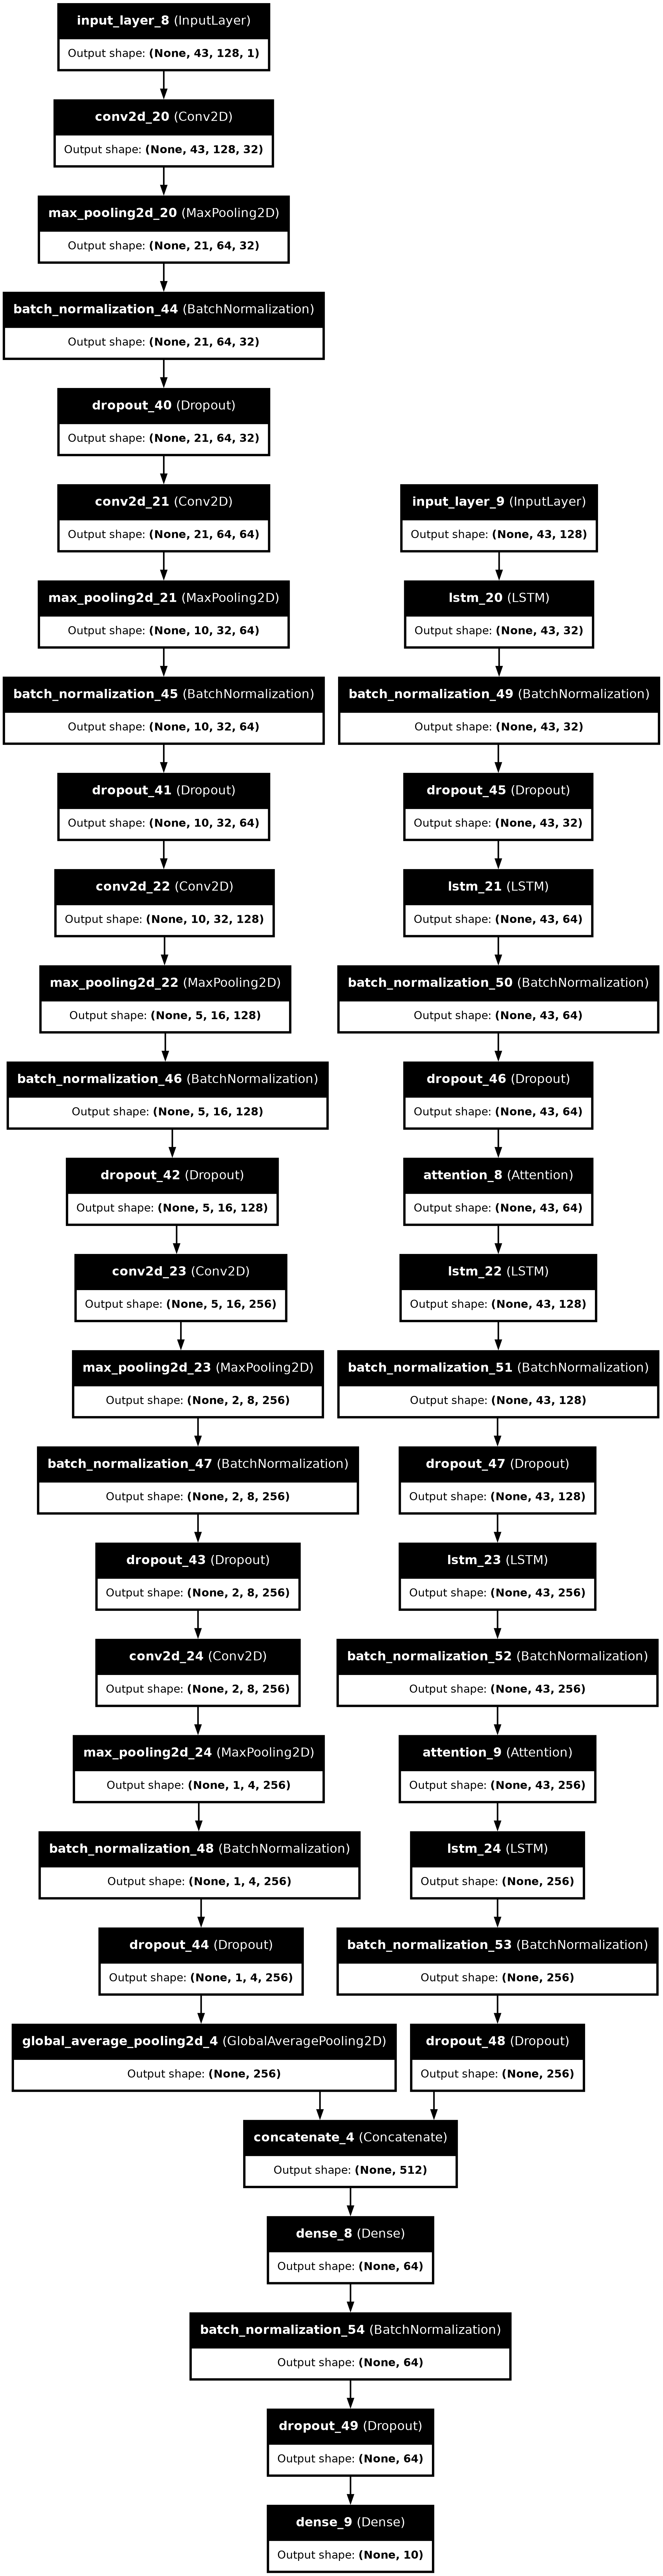

In [110]:
from keras.utils import plot_model

# 假設 combined_model 是您的合併模型
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [111]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math
from tensorflow.keras.callbacks import ModelCheckpoint

def lr_decay(epoch):
    initial_lr = 0.01
    decay_factor = 0.1
    decay_epochs = 10
    lrate = initial_lr * math.pow(decay_factor, math.floor((1 + epoch) / decay_epochs))
    return lrate

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7)
lr_scheduler = LearningRateScheduler(lr_decay)
checkpointer = ModelCheckpoint(filepath="/kaggle/working/model0412.keras", 
                                verbose=1, save_best_only=True)
# 定義 Early Stopping 回調函數，當驗證集準確度不再改善時停止訓練
earlyStopping = EarlyStopping(
    monitor='val_accuracy',  # 監控驗證集的準確度
    patience=20,              # 忍耐的 epochs 數，若驗證集準確度在 30 個 epochs 內沒有改善則停止訓練
    min_delta=0.001,          # 視為改善的最小變化量
    restore_best_weights=True  # 是否恢復到最佳權重
)

# 使用 Early Stopping 回調函數進行模型訓練
history = model.fit(
    x=[trainX,trainX],                   # 訓練集特徵
    y=trainY,                   # 訓練集標籤
    batch_size=8,
    validation_data=([valX,valX], valY),  # 驗證集特徵與標籤
    shuffle=True,
    epochs=100,                # 訓練的 epochs 次數
    callbacks=[earlyStopping,lr_scheduler]  # 使用的回調函數列表，這裡只使用了 Early Stopping
)

Epoch 1/100


2024-04-12 05:15:37.186148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_29_1/dropout_40_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.2788 - loss: 2.3796 - top_2_categorical_accuracy: 0.4381 - val_accuracy: 0.1056 - val_loss: 8.4954 - val_top_2_categorical_accuracy: 0.3111 - learning_rate: 0.0100
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5839 - loss: 1.2186 - top_2_categorical_accuracy: 0.7668 - val_accuracy: 0.1611 - val_loss: 3.1274 - val_top_2_categorical_accuracy: 0.4389 - learning_rate: 0.0100
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6429 - loss: 1.0093 - top_2_categorical_accuracy: 0.8146 - val_accuracy: 0.3611 - val_loss: 2.6831 - val_top_2_categorical_accuracy: 0.5611 - learning_rate: 0.0100
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6355 - loss: 1.0277 - top_2_categorical_accuracy: 0.8030 - val_accuracy: 0.4611 - val_loss: 1.6933 - val_top_2_categorical_accuracy: 0.6944 - learning_rate: 0.0100
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6915 - loss: 0.8938 - top

In [112]:
# model.save("/kaggle/working/model0411.h5")

In [113]:
historyDf = pd.DataFrame(history.history)
historyDf

,accuracy,loss,top_2_categorical_accuracy,val_accuracy,val_loss,val_top_2_categorical_accuracy,learning_rate
0,0.364395,1.968904,0.547983,0.105556,8.495386,0.311111,1.000000e-02
1,0.584145,1.244868,0.766342,0.161111,3.127443,0.438889,1.000000e-02
2,0.642559,1.062401,0.796940,0.361111,2.683056,0.561111,1.000000e-02
3,0.652295,1.026641,0.819193,0.461111,1.693257,0.694444,1.000000e-02
4,0.703755,0.876830,0.851182,0.622222,1.784250,0.744444,1.000000e-02
5,0.720445,0.861995,0.859527,0.661111,1.329349,0.777778,1.000000e-02
6,0.777469,0.691139,0.897079,0.750000,1.082852,0.838889,1.000000e-02
7,0.745480,0.733480,0.890125,0.805556,0.571438,0.933333,1.000000e-02
8,0.780250,0.645528,0.923505,0.783333,0.859117,0.866667,1.000000e-02
9,0.862309,0.471869,0.938804,0.833333,0.502698,0.933333,1.000000e-03


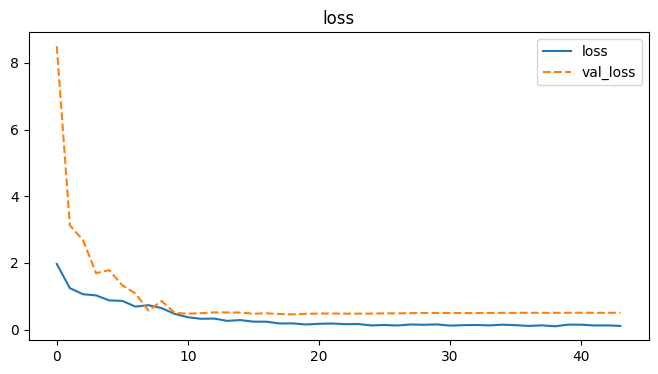

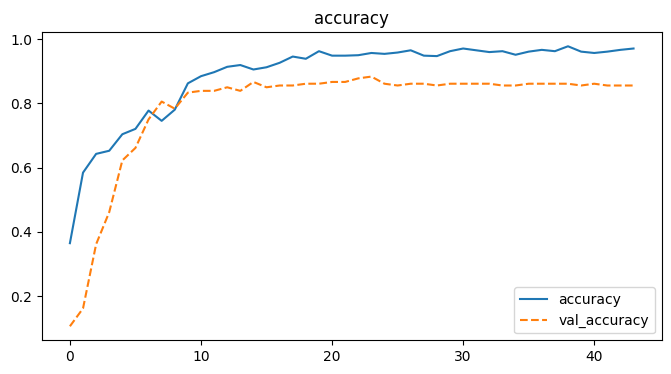

In [114]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()

# Accuracy
fig, ax = plt.subplots(figsize=(8,4))
plt.title('accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.legend()
plt.show()

In [115]:
# Evaluating model
score = model.evaluate([testX,testX], testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8299 - loss: 0.5513 - top_2_categorical_accuracy: 0.9314
Validation accuracy of model : 83.00%


In [116]:
# 在測試集上進行預測
y_pred = model.predict([testX,testX])

# 將預測轉換為類別
y_pred_classes = np.argmax(y_pred, axis=1)
testY_classes = np.argmax(testY, axis=1)

# 顯示分類報告
print("Classification Report:")
print(classification_report(testY_classes, y_pred_classes))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      1.00      1.00         2
           2       0.75      0.69      0.72        13
           3       0.82      0.93      0.87        15
           4       1.00      0.50      0.67        12
           5       1.00      0.88      0.93         8
           6       0.91      1.00      0.95        10
           7       0.75      0.90      0.82        10
           8       0.82      0.90      0.86        10
           9       0.77      0.77      0.77        13

    accuracy                           0.83       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.84      0.83      0.82       100



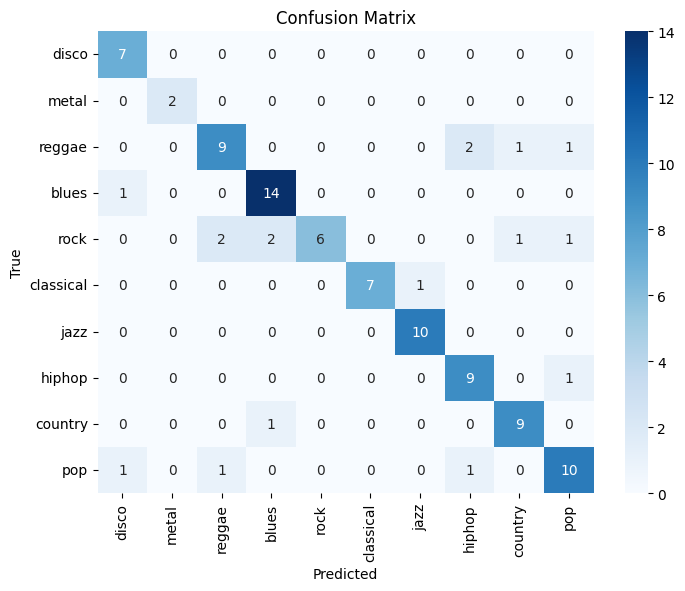

In [117]:
# 顯示混淆矩陣
conf_matrix = confusion_matrix(testY_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

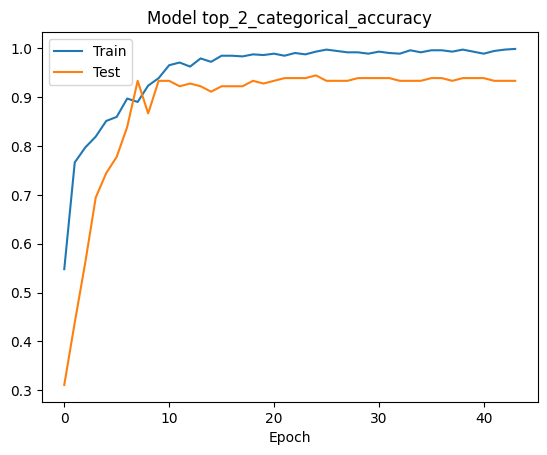

In [118]:
plt.plot(history.history['top_2_categorical_accuracy'])
plt.plot(history.history['val_top_2_categorical_accuracy'])
plt.title('Model top_2_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'],loc='upper left')
plt.show()

In [119]:
# # 函數：從一首特定的音樂文件中進行風格類別預測
# def predict_music_style_from_audio(audio_file, target_shape):
#     # 預處理音樂數據
#     preprocessed_audio = extractFeatures(audio_file)
    
#     preprocessed_audio = preprocessed_audio.reshape(1, preprocessed_audio.shape[0], preprocessed_audio.shape[1], 1)

#     # 將音樂數據提供給模型進行預測
#     prediction = model.predict(preprocessed_audio)
    
#     # 返回預測結果
#     return prediction

# # 指定要辨識風格類別的音樂文件路徑
# audio_file_path = 'predict_music/Not Falling_0001.mp3'

# # 在應用程序中調用函數並顯示結果
# predicted_style = predict_music_style_from_audio(audio_file_path, (43, 128))

# # 將類別標籤與預測概率直對應的字典
# predicted_probabilities = {}

# # 將每個類別與其對應的預測概率值相互對應
# for i, class_label in enumerate(class_labels):
#     predicted_probabilities[class_label] = predicted_style[0][i]

# # 打印每個類別與其對應的預測概率值
# print("各類別的預測概率值:")
# for class_label, probability in predicted_probabilities.items():
#     print(f"{class_label}: {probability}")

In [120]:
# # 假設 predicted_style 是從模型獲得的預測結果的向量
# predicted_class_index = np.argmax(predicted_style)

# # 使用提供的 class_labels 從中獲取對應的音樂風格類別
# predicted_music_style = class_labels[predicted_class_index]

# # 打印預測的音樂風格類別
# print("Predicted music style:", predicted_music_style)